This is a jupyter notebook to get all the data from my shapefiles, group together the objects with the same label and then save the data as png images of a size 10000 x 10000 pix (which correspond to the size of my bounding boxes).

In [140]:
import random
import geopandas as gpd
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
#from PIL import Image
import os
import numpy as np
import networkx as nx

# Load the box module from shapely to create box objects
from shapely.geometry import box
from shapely.geometry import Point, Polygon, MultiPoint, shape, LineString
from shapely.ops import triangulate
from shapely.affinity import translate

from earthpy import clip as cl
import pickle

# to display images inline
get_ipython().magic(u'matplotlib inline')
matplotlib.use('Agg')# not sure what I used it for

# some custom files
from img_helpers import get_all_images_in_folder
%matplotlib inline

In [2]:
# define the region folder
global_path = "./lorraine"

## ROADS

In [3]:
# load all the shapely files related to ROADS
fp_road = global_path + "/gis_osm_roads_free_1.shp"
all_roads = gpd.read_file(fp_road)
all_roads = all_roads.to_crs("EPSG:2154") 

In [4]:
all_roads.head() # small demo of the roads 

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2284506,5131,motorway_link,None,A 31,F,70,0,F,F,"LINESTRING (926317.999 6848103.926, 926303.576..."
1,2306356,5131,motorway_link,None,A 31,F,110,0,F,F,"LINESTRING (925999.230 6847969.946, 926002.566..."
2,2371422,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (911516.762 6818357.130, 911510.086..."
3,2371423,5141,service,None,None,F,0,0,F,F,"LINESTRING (911470.001 6818072.927, 911471.198..."
4,2371424,5141,service,None,None,F,0,0,F,F,"LINESTRING (911445.587 6817975.063, 911440.070..."


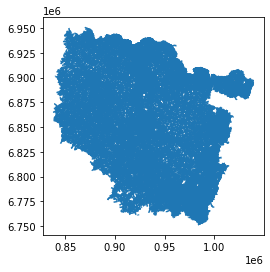

In [5]:
# we can plot all the Roads network of cote d'Or
all_roads.plot()

In [11]:
print(all_roads.geometry[0])

LINESTRING (926317.9987010306 6848103.92620272, 926303.5764659034 6848101.839877395, 926122.8919396002 6848073.41706533, 926050.0065529 6848066.585298013, 926035.1948267163 6848066.553982835, 926024.2547940069 6848067.919535651, 926014.1368203793 6848071.063934754, 926003.4538814165 6848075.85531441, 925994.7606743721 6848081.569742412, 925987.7750873129 6848087.128104702, 925978.4724483083 6848096.579540522, 925974.539551257 6848102.056429515)


In [117]:
all_roads.geometry[0].length

358.1584456455162

In [149]:
final_data = []
final_data = divide_road_into_segments(final_data, 12, all_roads.geometry[0],1, 10 )

0.02857142857142857
LINESTRING (926317.9987010306 6848103.92620272, 926317.970423942 6848103.922112147)
0.05714285714285714
LINESTRING (926317.9987010306 6848103.92620272, 926317.9421468533 6848103.918021574)
0.08571428571428572
LINESTRING (926317.9987010306 6848103.92620272, 926317.9138697647 6848103.913931001)
0.11428571428571428
LINESTRING (926317.9987010306 6848103.92620272, 926317.885592676 6848103.909840428)
0.14285714285714285
LINESTRING (926317.9987010306 6848103.92620272, 926317.8573155873 6848103.905749855)
0.17142857142857143
LINESTRING (926317.9987010306 6848103.92620272, 926317.8290384987 6848103.901659282)
0.2
LINESTRING (926317.9987010306 6848103.92620272, 926317.8007614102 6848103.897568709)
0.22857142857142856
LINESTRING (926317.9987010306 6848103.92620272, 926317.7724843214 6848103.893478136)
0.2571428571428571
LINESTRING (926317.9987010306 6848103.92620272, 926317.7442072327 6848103.889387563)
0.2857142857142857
LINESTRING (926317.9987010306 6848103.92620272, 926317.

In [147]:
print(final_data[8][2].length)

0.257142857113466


In [128]:
print(final_data[0][2].length)

358.1584456455162


Data type - geographical projection of he data used.

In [13]:
# check the projection of the data - I need espg 2154, otherwise re-project using geopandas
all_roads.crs
len(all_roads)

305429

## Houses

In [6]:
# Load all the data from the BUILDINGS caegory
fp_bati = global_path + "/buildings_merged.shp"
# Read file using gpd.read_file()
all_buildings = gpd.read_file(fp_bati)
all_buildings = all_buildings.to_crs("EPSG:2154") 


In [7]:
all_buildings.crs

<Projected CRS: EPSG:2154>
Name: RGF93 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
len(all_buildings)

880615

In [9]:
#places of worship
churches = global_path +  "/gis_osm_pofw_free_1.shp"
churches = gpd.read_file(churches)
churches=churches.to_crs("EPSG:2154") 

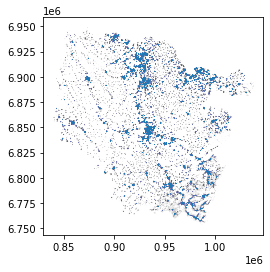

In [10]:
all_buildings.plot()

In [11]:
## Places - POI

In [12]:
fp_poi = global_path + "/gis_osm_pois_free_1.shp" 
# Read file using gpd.read_file()
poi = gpd.read_file(fp_poi)
poi=poi.to_crs("EPSG:2154") 
poi.fclass.unique()
towers = poi.loc[poi['fclass'] == 'tower']
castels = poi.loc[poi['fclass'] == 'castle']
forts = poi.loc[poi['fclass']=='fort']
monuments = poi.loc[poi['fclass']=='monument']

In [13]:
print("statisics over all POI objects. There %d churches, %d towers, %d monuments, %d forts, %d castles and % ordinary buildings" 
      %(len(churches),len(towers),len(monuments), len(forts), len(castels), len(all_buildings)))

statisics over all POI objects. There 308 churches, 58 towers, 129 monuments, 5 forts, 88 castles and  3267747rdinary buildings


## WATER 

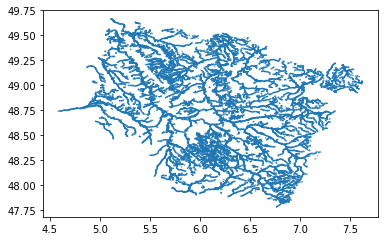

In [14]:
fp_water =  global_path + "/gis_osm_waterways_free_1.shp"
all_water = gpd.read_file(fp_water)
all_water.plot()
len(all_water)
all_water = all_water.to_crs("EPSG:2154")

In [15]:
all_water.head()

,osm_id,code,fclass,width,name,geometry
0,4815107,8103,canal,0,Canal de la Marne au Rhin,"LINESTRING (984489.607 6851800.092, 984564.608..."
1,4815109,8103,canal,0,Canal de la Marne au Rhin,"LINESTRING (1010254.674 6854483.897, 1010249.1..."
2,8107949,8101,river,0,La Moselle,"LINESTRING (955360.123 6798378.653, 955352.697..."
3,9330785,8103,canal,0,Canal de Jouy,"LINESTRING (924920.267 6889646.597, 924977.952..."
4,10041506,8103,canal,0,None,"LINESTRING (925400.473 6865293.269, 925410.457..."


## SPORT TERRITORIES

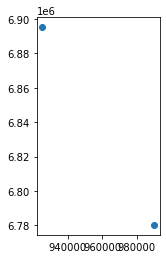

In [16]:
fp_sport = global_path +  "/gis_osm_pois_free_1.shp"
data_sport = gpd.read_file(fp_sport)
data_sport=data_sport.to_crs("EPSG:2154") 
data_sport = data_sport.loc[data_sport['fclass'] == 'stadium']
data_sport.plot()

In [17]:
len(data_sport)

2

## CEMETRIES

,osm_id,code,fclass,name,geometry
3,10505105,2015,graveyard,None,"POLYGON ((961406.056 6891837.077, 961440.938 6..."
6,16138907,2015,graveyard,None,"POLYGON ((910061.527 6898490.181, 910135.790 6..."
8,22327821,2015,graveyard,Nécropole nationale du Trottoir (les Eparges),"POLYGON ((890344.007 6888228.795, 890426.964 6..."
9,22369855,2015,graveyard,Cimetière de Préville,"POLYGON ((932564.288 6848078.090, 932567.703 6..."
10,22529520,2015,graveyard,None,"POLYGON ((931210.096 6845410.829, 931212.047 6..."


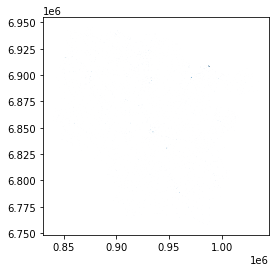

In [18]:
fp_cemetries = global_path +  "/gis_osm_pois_a_free_1.shp"
data_cemetries = gpd.read_file(fp_cemetries)
data_cemetries=data_cemetries.to_crs("EPSG:2154") 
#pick the graveyards
data_cemetries =  data_cemetries.loc[data_cemetries['fclass'] =='graveyard']
data_cemetries.plot()
data_cemetries.head() 

## RAILROADS

In [19]:
#railroads
fp_rail = global_path + "/gis_osm_railways_free_1.shp"
data_rail  = gpd.read_file(fp_rail)
data_rail = data_rail.to_crs("EPSG:2154") 
print(len(data_rail))

9002


## BOUNDING BOXES FROM THE IMAGES

Finally, load the bounding boxes

In [45]:
image_polygons = gpd.read_file('D:/IGN_data/BD/polygons/image_polygons_54.shp')

In [46]:
image_polygons.crs

<Projected CRS: PROJCS["RGF93_Lambert_93",GEOGCS["RGF93",DATUM["Re ...>
Name: RGF93_Lambert_93
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [50]:
image_polygons

,ID,PREC_PLANI,PREC_ALTI,ORIGIN_BAT,NATURE,HAUTEUR,Z_MIN,Z_MAX,geo_ID,geometry
0,BATIMENT0000000053807577,1.5,1.0,Autre,Gare,9,226.2,226.3,6,"POLYGON ((933427.610 6847868.515, 933427.610 6..."
1,BATIMENT0000000053740974,1.5,1.0,Autre,Gare,6,222.8,225.2,1,"POLYGON ((888816.597 6930223.834, 888816.597 6..."
2,BATIMENT0000000053767449,1.5,1.0,Autre,Gare,12,221.6,227.1,2,"POLYGON ((910011.111 6876467.135, 910011.111 6..."
3,BATIMENT0000000053771142,1.5,1.0,Autre,Gare,11,186.4,193.0,3,"POLYGON ((923515.477 6870907.788, 923515.477 6..."
4,BATIMENT0000000053777052,1.5,1.0,Autre,Gare,7,189.8,192.7,4,"POLYGON ((925265.595 6864707.886, 925265.595 6..."
...,...,...,...,...,...,...,...,...,...,...
2120,BATIMENT0000000053875433,10.0,9999.0,Autre,Monument,0,-99.0,-99.0,2120,"POLYGON ((978947.823 6826816.155, 978947.823 6..."
2121,BATIMENT0000000053880944,10.0,9999.0,Autre,Monument,0,-99.0,-99.0,2121,"POLYGON ((976491.749 6822570.362, 976491.749 6..."
2122,BATIMENT0000000053847778,10.0,9999.0,Autre,Monument,0,-99.0,-99.0,2122,"POLYGON ((963230.770 6838787.953, 963230.770 6..."
2123,BATIMENT0000000053876671,10.0,9999.0,Autre,Chapelle,0,-99.0,-99.0,2123,"POLYGON ((962822.350 6826286.650, 962822.350 6..."


## graph creation routine

In [25]:
def calculate_number_of_points(geometry):
    ''' function calculates number of points in the object '''
    if geometry.type == 'Polygon':
        return len(geometry.exterior.coords)
    elif geometry.type == 'LineString':
        return len(geometry.coords)
    else:
        try:
            return(len(geometry.coords))
        except:
            print(f"Error! Unknown type detected: {type(geometry)}, returning 0")
            return 0
def calculate_eccentricity(geometry):
    ''' function calculates eccentricity measure (w/l of min envelop rectangle) '''
    envelop_rect = geometry.minimum_rotated_rectangle
    minx, miny, maxx, maxy = envelop_rect.bounds
    width = maxx - minx
    height = maxy - miny
    if height ==0 or width ==0:
        return 0
    if width < height:
        return  width/height
    else:
        return height/width
        
def calculate_perimeter(geometry):
    ''' function calculates the perimeter of the shapely geometry '''
    return geometry.length
# unit tests
# calculate_perimeter(buildings3.geometry[1])

In [26]:
def get_node_attributes(shapely_geometry, poly_bound, nature, within_poly = True):
    """ function returns attributes of road/house node"""
    attributes = {}
    obj_type = nature
    if within_poly:
        obj_length = calculate_perimeter(shapely_geometry)
        frame_perimeter = poly_bound.length
        obj_normed_length = obj_length/frame_perimeter 
        obj_points = calculate_eccentricity(shapely_geometry)
    else:
        obj_normed_length = 0
        obj_points = 0
    attributes = {'nature': obj_type, 'normed_length':obj_normed_length, 
                 'eccentricity':obj_points}
    return attributes

In [27]:
def calculate_distance(obj1, obj2):
    ''' this fucntion calculates the minimum distance between the objects:
    if an object is a polygon, its center is considered as a central point
    if an object is a line, the distance is the lenght of the normal from another object,
    if both objects are lines, the distance is 0'''
    d = None
    if obj1.type == 'Polygon' and obj2.type == 'Polygon':
        #print("polyg polyg")
        proj_dist = obj1.centroid.distance(obj2.centroid) #euclidean distance
        d = proj_dist
    elif obj1.type == 'LineString' and obj2.type == 'Polygon':
        #print("linestr polyg")
        proj_dist= obj2.centroid.distance(obj1) 
#         print(proj_dist)
#         print(obj1.project(obj2.centroid))
        d = proj_dist
    elif obj2.type=='LineString' and obj1.type == 'Polygon':
        #print(" polyg linestr")
        proj_dist= obj1.centroid.distance(obj2)     
        d = proj_dist
    elif obj1.type == 'LineString' and  obj2.type=='LineString':
        #print(" linestr linestr")
        if obj1.intersects( obj2):
            d = 0
        else:
            d = None
    elif obj1.type == 'shapely.geometry.LineString' and  obj2.type=='shapely.geometry.LineString':
        #print(" linestr linestr")
        if obj1.intersects( obj2):
            d = 0
        else:
            d = None    
    else:
        print(" unkn unkn")
        try:
            print(type(obj1),type(obj2))
            d = obj2.distance(obj1.centroid)
        except:
            print('Distance calc didnt work')
            d = None
    #print(f"d is {d} for objects {type(obj1)} {type(obj2)}")
    return d

In [28]:
def determine_if_connected(geodf, idx1, idx2, delaunay_tringales):
    ' check if the nodes are connected in the graph (the centroinds should belong to one triangle):'
    connected = False
    for d_cell in delaunay_tringales:
        if d_cell.intersects(geodf.centroid[idx1]) and d_cell.intersects(geodf.centroid[idx2]): #if they belong to one cell, they are connected
            return True
        
    return connected
        

In [239]:
def determine_if_connected_rng(geodf, idx1, idx2, distance_matrix):
    ' check if the nodes are connected in the graph (the centroinds should belong to one triangle):'
    connected = False
    dist = distance_matrix[idx1][idx2]
    dmax =[]
    for i in range(distance_matrix.shape[0]):
        if i!=idx1 and i!=idx2:
            dmax.append(max(distance_matrix[idx1][i], distance_matrix[idx2][i]))   
    connected = dist <= min(dmax)        
    return connected,dist

In [30]:
def calculate_distance_matrix(geodf):
    dist_matrix = np.zeros((len(geodf),len(geodf)))
    for shp1 in range(0, len(geodf)):
         for shp2 in range(0, len(geodf)):
                dist_matrix[shp1][shp2] = geodf.centroid[shp1].distance(geodf.centroid[shp2])
        
    np.fill_diagonal(dist_matrix, float('inf'))
    return dist_matrix

In [31]:
def calculate_centroids(geodf):
    geodf = geodf.assign(centroid="")
    for i in range(len(geodf)):
        if type(geodf.loc[i, ('geometry')]) == 'Point':
            geodf.loc[i, ('centroid')] = geodf.loc[i, ('geometry')]
        else:
            geodf.centroid[i] = geodf.loc[i, ('geometry')].centroid
            
    return geodf

In [32]:
def create_graph_where_object_is_node(gp_frame, poly = None, threshold = 100):
    ''' function takes the pandas frame and creates the graph, where the nodes are rivers and roads,
    and buildings, and sportive objects etc.
    Nodes have the following attributes: 
    a) type of object (road/water/house/church etc)
    b) num of angles / points in the shape geometry
    c) length (divided by HxW of the polygon to scale)
    Edges have no attributes:
    they are calculated by delaunay triangulation
    '''
    pos = {} #dictionary for node coord
    net = nx.Graph() # empty graph   
    attr = {}
    triangles = triangulate(MultiPoint(gp_frame.centroid.tolist()))
    for shp1 in range(0, len(gp_frame)-1): # for each object
        # the geometry property here may be specific to my shapefile
        object1 = gp_frame['geometry'].iloc[shp1] #get the line
        pos[shp1] = [gp_frame['geometry'].iloc[shp1].centroid.x,  gp_frame['geometry'].iloc[shp1].centroid.y]
        # get all line attributes
        attributes = get_node_attributes(object1, poly, gp_frame['nature'].iloc[shp1],gp_frame['withinPoly'].iloc[shp1])
        net.add_node(shp1) # add node
        attr[shp1]= attributes # nested dict
        for shp2 in range(shp1+1, len(gp_frame)):
            object2 = gp_frame['geometry'].iloc[shp2] #get the second object
            connected = determine_if_connected(gp_frame, shp1, shp2, triangles)
            if connected: # if intersects               
                net.add_edge(shp1, shp2) # edge with an attribute

        # add the last element - coz first loop is not for all values, and last node needs attributes
        attributes = get_node_attributes(object2, poly, gp_frame['nature'].iloc[shp2],gp_frame['withinPoly'].iloc[shp2])
        attr[len(gp_frame)-1]= attributes # nested dict
        net.add_node(shp2) # add node 
        nx.set_node_attributes(net, attr)

        pos[shp2] = [gp_frame['geometry'].iloc[shp2].centroid.x, gp_frame['geometry'].iloc[shp2].centroid.y]

    return net, pos

In [233]:
def create_rng_graph(gp_frame, poly = None, threshold = 100):
    ''' function takes the pandas frame and creates the graph, where the nodes are rivers and roads,
    and buildings, and sportive objects etc.
    Nodes have the following attributes: 
    a) type of object (road/water/house/church etc)
    b) eccentricity
    c) length (divided by HxW of the polygon to scale)
    Edges have attributes based on the normalized distance between the points:
    they are calculated by the algorithm proposed 
    here: 
    https://en.wikipedia.org/wiki/Relative_neighborhood_graph
    '''
    pos = {} #dictionary for node coord
    net = nx.Graph() # empty graph   
    attr = {}
    dist_matrix = calculate_distance_matrix(gp_frame) 
    for shp1 in range(0, len(gp_frame)-1): # for each object
        # the geometry property here may be specific to my shapefile
        object1 = gp_frame['geometry'].iloc[shp1] #get the line
        pos[shp1] = [gp_frame['geometry'].iloc[shp1].centroid.x,  gp_frame['geometry'].iloc[shp1].centroid.y]
        # get all line attributes
        attributes = get_node_attributes(object1, poly, gp_frame['nature'].iloc[shp1],gp_frame['withinPoly'].iloc[shp1])
        net.add_node(shp1) # add node
        attr[shp1]= attributes # nested dict
        for shp2 in range(shp1+1, len(gp_frame)):
            object2 = gp_frame['geometry'].iloc[shp2] #get the second object
            connected, dist = determine_if_connected_rng(gp_frame, shp1, shp2, dist_matrix)
            if connected: # if intersects               
                net.add_edge(shp1, shp2, distance = dist) # edge with an attribute

        # add the last element - coz first loop is not for all values, and last node needs attributes
        attributes = get_node_attributes(object2, poly, gp_frame['nature'].iloc[shp2],gp_frame['withinPoly'].iloc[shp2])
        attr[len(gp_frame)-1]= attributes # nested dict
        net.add_node(shp2) # add node 
        nx.set_node_attributes(net, attr)

        pos[shp2] = [gp_frame['geometry'].iloc[shp2].centroid.x, gp_frame['geometry'].iloc[shp2].centroid.y]

    return net, pos

In [161]:
from shapely.ops import split
def divide_road_into_segments(final_data, nature, geoobject, inside_polygon =1, lenght = 10 ):
    ''' this function divides the road into a set of segments '''
    number_of_segments = int(geoobject.length//lenght)
   
    if number_of_segments>1:
        for i in range(1, number_of_segments):
            #cutting_point=geoobject.interpolate(i/number_of_segments)
            #dist= geoobject.project(cutting_point)
            segment = cut(geoobject,lenght)
            segment, geoobject  = segment[0], segment[1]
            final_data.append([nature, 1, segment])
    else:
        final_data.append([nature, 1,  geoobject])
    return final_data
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]               
    
    

In [61]:
def clean_and_append(final_data, data_segment, nature, polygon_bbox):
    ''' function copies data from a data frame to a new data list of a following structure:
    nature
    within the image (bool) if the object is entirely inside the polygon or not
    geometry
    returns list of lists with objects like  [[nat, within, geom], [], []...]  '''
    # if it is line object
    if data_segment.empty == True:
        pass     
    else:
        # check if object is completely within the polygon
        for index, row in data_segment.iterrows(): # for each element           
            if row['geometry'].geom_type == 'MultiPolygon' or row['geometry'].geom_type == 'MultiLineString':
                for single_obj in row['geometry']:
                        #print("data ", len(final_data), 'obj', type(single_obj))
                        final_data.append([nature, 1, single_obj]) 
                print('a multistring detected and transformed') 
            elif row['geometry'].is_empty or row['geometry']==[]:
                pass
            else:   
                final_data.append([nature, 1, row['geometry']]) # polygons are classified depending on their status always within 

    return final_data

In [170]:
def clean_and_append(final_data, data_segment, nature, polygon_bbox):
    ''' function copies data from a data frame to a new data list of a following structure:
    nature
    within the image (bool) if the object is entirely inside the polygon or not
    geometry
    returns list of lists with objects like  [[nat, within, geom], [], []...]  '''
    # if it is line object
    if data_segment.empty == True:
        pass     
    else:
        # check if object is completely within the polygon
        for index, row in data_segment.iterrows(): # for each element           
            if row['geometry'].geom_type == 'MultiPolygon' or row['geometry'].geom_type == 'MultiLineString':
                for single_obj in row['geometry']:
                        if nature in [12,13,14]:
                            final_data = divide_road_into_segments(final_data, nature, single_obj, 1, 15)
                        else:
                            final_data.append([nature, 1, single_obj]) 
                print('a multistring detected and transformed') 
            elif row['geometry'].is_empty or row['geometry']==[]:
                pass
            else:
                if nature in [12,13,14]:
                    final_data = divide_road_into_segments(final_data, nature, row['geometry'], 1, 15)
                else:
                    final_data.append([nature, 1, row['geometry']]) # polygons are classified depending on their status always within 

    return final_data

In [37]:
def clip_data(pd_obj, pd_polyg):
    try:
        sg = cl.clip_shp(pd_obj, pd_polyg) #all_roads[all_roads.geometry.intersects(polygon_bbox)] #extract segments of roads
    except:
        sg = pd.DataFrame()
    return sg
    

In [246]:
for i in range(1,len(image_polygons)) : # len(image_polygons) (len(image_polygons)-3,len(image_polygons)-2)
    # randomly shift the polygon box
    polygon_bbox = image_polygons.iloc[i-1:i]
    data = []
    # lines

    sg_roads = clip_data(all_roads, polygon_bbox)  #all_roads[all_roads.geometry.intersects(polygon_bbox)] #extract segments of roads
    data = clean_and_append(data, sg_roads, 12, polygon_bbox)
    sg_water = clip_data(all_water, polygon_bbox)#all_water[all_water.geometry.intersects(polygon_bbox)] #extract segments of water
    data = clean_and_append(data, sg_water, 13, polygon_bbox)
    sg_data_rail = clip_data(data_rail, polygon_bbox)#data_rail[data_rail.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_rail, 14, polygon_bbox)
    # objects
    sg_houses = clip_data(all_buildings, polygon_bbox) #all_buildings[all_buildings.geometry.intersects(polygon_bbox)] #extract segments of buildings
    data = clean_and_append(data, sg_houses, 1, polygon_bbox)
    sg_towers = clip_data(towers, polygon_bbox)#towers[towers.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_towers, 5, polygon_bbox)
    sg_churches = clip_data(churches, polygon_bbox) # churches[churches.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_churches, 6, polygon_bbox)
    sg_castels = clip_data(castels, polygon_bbox)#castels[castels.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_castels, 7, polygon_bbox)
    sg_forts = clip_data(forts, polygon_bbox)#forts[forts.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_forts, 8, polygon_bbox)
    sg_monuments = clip_data(monuments, polygon_bbox)#monuments[monuments.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_monuments, 9, polygon_bbox)
    sg_data_cemetries = clip_data(data_cemetries, polygon_bbox)#data_cemetries[data_cemetries.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_cemetries, 10, polygon_bbox)
    sg_sport = clip_data(data_sport, polygon_bbox)#data_sport[data_sport.geometry.intersects(polygon_bbox)] #extract segments of sport  things
    data = clean_and_append(data, sg_sport, 11, polygon_bbox)
    combined_pd = pd.DataFrame(data, columns = ['nature','withinPoly', 'geometry']) 
    sg_houses_rem =  pd.concat([sg_sport, sg_towers,sg_churches, sg_data_cemetries, sg_castels,sg_forts,sg_monuments],ignore_index=True)
    combined_pd = calculate_centroids(combined_pd)
    name = 'D:/IGN_data/BD/graphs/osm_all_objects/54_rng/'
    print(name +'graph_main'+ str(i).zfill(5) +'.pickle')
    print(len(combined_pd))
    if combined_pd.empty:
        G = nx.empty_graph()
    else:
        G, pos = create_rng_graph(gp_frame=combined_pd, poly=polygon_bbox,  threshold = 35)
    nx.write_gpickle(G, name + str(i).zfill(5) +'_graph_main' +'.pickle', protocol=4)
    with open(name + str(i).zfill(5)  +'_position.pickle', 'wb') as handle:
        pickle.dump(pos, handle)

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00001.pickle
246


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00002.pickle
209


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00003.pickle
60
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00004.pickle
172


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00005.pickle
100


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00006.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00007.pickle
293


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00008.pickle
155


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00009.pickle
214


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00010.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00011.pickle
111


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00012.pickle
89


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00013.pickle
35


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00014.pickle
112


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00015.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00016.pickle
195


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00017.pickle
132


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00018.pickle
187


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00019.pickle
102


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00020.pickle
240


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00021.pickle
142


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00022.pickle
133


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00023.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00024.pickle
174


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00025.pickle
173


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00026.pickle
171


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00027.pickle
92


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00028.pickle
107


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00029.pickle
197


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00030.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00031.pickle
159


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00032.pickle
164


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00033.pickle
128


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00034.pickle
102


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00035.pickle
277


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00036.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00037.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00038.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00039.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00040.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00041.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00042.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00043.pickle
54
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00044.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00045.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00046.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00047.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00048.pickle
100


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00049.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00050.pickle
29


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00051.pickle
104


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00052.pickle
90


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00053.pickle
39


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00054.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00055.pickle
110


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00056.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00057.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00058.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00059.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00060.pickle
86


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00061.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00062.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00063.pickle
119


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00064.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00065.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00066.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00067.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00068.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00069.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00070.pickle
57
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00071.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00072.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00073.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00074.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00075.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00076.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00077.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00078.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00079.pickle
57
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00080.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00081.pickle
33


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00082.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00083.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00084.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00085.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00086.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00087.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00088.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00089.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00090.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00091.pickle
63
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00092.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00093.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00094.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00095.pickle
43
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00096.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00097.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00098.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00099.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00100.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00101.pickle
59
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00102.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00103.pickle
110


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00104.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00105.pickle
92


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00106.pickle
44


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00107.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00108.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00109.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00110.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00111.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00112.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00113.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00114.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00115.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00116.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00117.pickle
93


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00118.pickle
34
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00119.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00120.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00121.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00122.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00123.pickle
68
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00124.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00125.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00126.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00127.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00128.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00129.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00130.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00131.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00132.pickle
83
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00133.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00134.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00135.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00136.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00137.pickle
91


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00138.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00139.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00140.pickle
52
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00141.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00142.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00143.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00144.pickle
46
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00145.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00146.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00147.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00148.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00149.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00150.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00151.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00152.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00153.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00154.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00155.pickle
68
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00156.pickle
80
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00157.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00158.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00159.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00160.pickle
98


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00161.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00162.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00163.pickle
71
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00164.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00165.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00166.pickle
63
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00167.pickle
101


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00168.pickle
55
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00169.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00170.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00171.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00172.pickle
122


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00173.pickle
38
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00174.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00175.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00176.pickle
86


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00177.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00178.pickle
48
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00179.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00180.pickle
134


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00181.pickle
81


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00182.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00183.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00184.pickle
104


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00185.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00186.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00187.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00188.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00189.pickle
101


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00190.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00191.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00192.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00193.pickle
39
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00194.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00195.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00196.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00197.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00198.pickle
82


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00199.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00200.pickle
105


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00201.pickle
99


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00202.pickle
99


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00203.pickle
105


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00204.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00205.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00206.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00207.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00208.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00209.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00210.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00211.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00212.pickle
103


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00213.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00214.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00215.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00216.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00217.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00218.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00219.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00220.pickle
98


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00221.pickle
135


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00222.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00223.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00224.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00225.pickle
160


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00226.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00227.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00228.pickle
120


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00229.pickle
152


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00230.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00231.pickle
93


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00232.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00233.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00234.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00235.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00236.pickle
152


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00237.pickle
145


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00238.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00239.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00240.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00241.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00242.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00243.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00244.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00245.pickle
77
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00246.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00247.pickle
59
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00248.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00249.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00250.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00251.pickle
98


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00252.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00253.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00254.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00255.pickle
31


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00256.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00257.pickle
31


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00258.pickle
33


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00259.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00260.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00261.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00262.pickle
34


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00263.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00264.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00265.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00266.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00267.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00268.pickle
120


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00269.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00270.pickle
44
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00271.pickle
90


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00272.pickle
82


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00273.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00274.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00275.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00276.pickle
70
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00277.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00278.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00279.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00280.pickle
34


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00281.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00282.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00283.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00284.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00285.pickle
66
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00286.pickle
114


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00287.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00288.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00289.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00290.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00291.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00292.pickle
90


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00293.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00294.pickle
96


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00295.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00296.pickle
49
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00297.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00298.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00299.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00300.pickle
81


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00301.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00302.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00303.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00304.pickle
56
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00305.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00306.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00307.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00308.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00309.pickle
63
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00310.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00311.pickle
104


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00312.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00313.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00314.pickle
53
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00315.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00316.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00317.pickle
81


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00318.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00319.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00320.pickle
89
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00321.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00322.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00323.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00324.pickle
79
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00325.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00326.pickle
62
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00327.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00328.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00329.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00330.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00331.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00332.pickle
43
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00333.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00334.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00335.pickle
48
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00336.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00337.pickle
46
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00338.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00339.pickle
109


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00340.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00341.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00342.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00343.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00344.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00345.pickle
81


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00346.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00347.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00348.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00349.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00350.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00351.pickle
34


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00352.pickle
82


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00353.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00354.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00355.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00356.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00357.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00358.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00359.pickle
55
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00360.pickle
44


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00361.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00362.pickle
51
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00363.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00364.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00365.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00366.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00367.pickle
86


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00368.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00369.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00370.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00371.pickle
44


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00372.pickle
67
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00373.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00374.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00375.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00376.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00377.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00378.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00379.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00380.pickle
90


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00381.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00382.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00383.pickle
107


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00384.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00385.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00386.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00387.pickle
69
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00388.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00389.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00390.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00391.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00392.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00393.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00394.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00395.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00396.pickle
75
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00397.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00398.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00399.pickle
49
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00400.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00401.pickle
89
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00402.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00403.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00404.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00405.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00406.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00407.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00408.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00409.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00410.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00411.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00412.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00413.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00414.pickle
34


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00415.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00416.pickle
39
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00417.pickle
39


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00418.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00419.pickle
40
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00420.pickle
101


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00421.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00422.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00423.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00424.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00425.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00426.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00427.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00428.pickle
89


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00429.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00430.pickle
39


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00431.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00432.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00433.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00434.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00435.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00436.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00437.pickle
55
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00438.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00439.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00440.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00441.pickle
62
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00442.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00443.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00444.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00445.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00446.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00447.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00448.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00449.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00450.pickle
30


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00451.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00452.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00453.pickle
33


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00454.pickle
30


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00455.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00456.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00457.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00458.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00459.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00460.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00461.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00462.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00463.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00464.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00465.pickle
33


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00466.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00467.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00468.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00469.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00470.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00471.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00472.pickle
23


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00473.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00474.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00475.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00476.pickle
30


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00477.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00478.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00479.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00480.pickle
36


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00481.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00482.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00483.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00484.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00485.pickle
35


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00486.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00487.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00488.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00489.pickle
101


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00490.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00491.pickle
46
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00492.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00493.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00494.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00495.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00496.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00497.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00498.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00499.pickle
46
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00500.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00501.pickle
69
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00502.pickle
82


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00503.pickle
85


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00504.pickle
49
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00505.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00506.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00507.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00508.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00509.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00510.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00511.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00512.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00513.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00514.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00515.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00516.pickle
44


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00517.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00518.pickle
92


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00519.pickle
36


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00520.pickle
81


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00521.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00522.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00523.pickle
92


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00524.pickle
34


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00525.pickle
24


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00526.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00527.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00528.pickle
89


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00529.pickle
101


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00530.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00531.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00532.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00533.pickle
44


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00534.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00535.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00536.pickle
103


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00537.pickle
109


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00538.pickle
141


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00539.pickle
124


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00540.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00541.pickle
125


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00542.pickle
112


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00543.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00544.pickle
106


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00545.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00546.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00547.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00548.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00549.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00550.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00551.pickle
31
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00552.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00553.pickle
61
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00554.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00555.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00556.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00557.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00558.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00559.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00560.pickle
89


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00561.pickle
24


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00562.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00563.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00564.pickle
91


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00565.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00566.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00567.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00568.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00569.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00570.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00571.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00572.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00573.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00574.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00575.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00576.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00577.pickle
95


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00578.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00579.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00580.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00581.pickle
64
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00582.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00583.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00584.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00585.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00586.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00587.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00588.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00589.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00590.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00591.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00592.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00593.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00594.pickle
23


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00595.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00596.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00597.pickle
25


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00598.pickle
33


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00599.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00600.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00601.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00602.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00603.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00604.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00605.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00606.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00607.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00608.pickle
107


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00609.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00610.pickle
49
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00611.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00612.pickle
44
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00613.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00614.pickle
106


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00615.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00616.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00617.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00618.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00619.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00620.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00621.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00622.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00623.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00624.pickle
93


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00625.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00626.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00627.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00628.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00629.pickle
28
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00630.pickle
82
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00631.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00632.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00633.pickle
74
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00634.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00635.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00636.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00637.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00638.pickle
87
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00639.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00640.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00641.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00642.pickle
74


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00643.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00644.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00645.pickle
20


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00646.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00647.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00648.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00649.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00650.pickle
112


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00651.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00652.pickle
75


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00653.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00654.pickle
96


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00655.pickle
137


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00656.pickle
105


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00657.pickle
101


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00658.pickle
100


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00659.pickle
91


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00660.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00661.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00662.pickle
82


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00663.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00664.pickle
94


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00665.pickle
92


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00666.pickle
86


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00667.pickle
16


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00668.pickle
36


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00669.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00670.pickle
16
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00671.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00672.pickle
69


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00673.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00674.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00675.pickle
30


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00676.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00677.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00678.pickle
26


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00679.pickle
26
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00680.pickle
83


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00681.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00682.pickle
54


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00683.pickle
31


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00684.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00685.pickle
87
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00686.pickle
118


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00687.pickle
10


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00688.pickle
73


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00689.pickle
76


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00690.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00691.pickle
110


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00692.pickle
91


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00693.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00694.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00695.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00696.pickle
16


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00697.pickle
15


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00698.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00699.pickle
26


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00700.pickle
24


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00701.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00702.pickle
82
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00703.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00704.pickle
18


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00705.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00706.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00707.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00708.pickle
18


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00709.pickle
106


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00710.pickle
96


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00711.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00712.pickle
70


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00713.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00714.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00715.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00716.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00717.pickle
66


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00718.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00719.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00720.pickle
58
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00721.pickle
107


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00722.pickle
39


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00723.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00724.pickle
14


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00725.pickle
31


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00726.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00727.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00728.pickle
26


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00729.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00730.pickle
10


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00731.pickle
108


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00732.pickle
71


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00733.pickle
44
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00734.pickle
48


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00735.pickle
16


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00736.pickle
40


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00737.pickle
24


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00738.pickle
80


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00739.pickle
20


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00740.pickle
78


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00741.pickle
51
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00742.pickle
83
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00743.pickle
58


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00744.pickle
53


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00745.pickle
57


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00746.pickle
115


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00747.pickle
120


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00748.pickle
123


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00749.pickle
44


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00750.pickle
67


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00751.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00752.pickle
18


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00753.pickle
47


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00754.pickle
13


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00755.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00756.pickle
52


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00757.pickle
59


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00758.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00759.pickle
71
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00760.pickle
63


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00761.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00762.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00763.pickle
68


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00764.pickle
98


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00765.pickle
39


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00766.pickle
62


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00767.pickle
59
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00768.pickle
42


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00769.pickle
45


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00770.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00771.pickle
41


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00772.pickle
61


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00773.pickle
81


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00774.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00775.pickle
51


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00776.pickle
46


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00777.pickle
55


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00778.pickle
105


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00779.pickle
104


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00780.pickle
87


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00781.pickle
84


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00782.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00783.pickle
50


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00784.pickle
123


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00785.pickle
105


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00786.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00787.pickle
118


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00788.pickle
35


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00789.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00790.pickle
30
a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00791.pickle
26


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00792.pickle
43


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00793.pickle
30


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00794.pickle
112


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00795.pickle
121


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00796.pickle
88


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00797.pickle
38


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00798.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00799.pickle
33


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00800.pickle
49


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00801.pickle
64


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of 

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00802.pickle
60


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00803.pickle
22


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00804.pickle
23
a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00805.pickle
79


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00806.pickle
65


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00807.pickle
132


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


a multistring detected and transformed
a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00808.pickle
77


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00809.pickle
56


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


a multistring detected and transformed
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00810.pickle
72


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
C:\Users\mkhokhlova\

D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00811.pickle
53
D:/IGN_data/BD/graphs/osm_all_objects/54_rng/graph_main00812.pickle
2


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


ValueError: min() arg is an empty sequence

In [178]:
  combined_pd

,nature,withinPoly,geometry,centroid
0,12,1,LINESTRING (925327.2859180488 6864830.18505749...,POINT (925332.5530139005 6864824.968406633)
1,12,1,LINESTRING (925336.7849862651 6864818.86494155...,POINT (925339.6419297593 6864812.00422186)
2,12,1,LINESTRING (925341.311696216 6864804.783255995...,POINT (925342.2604866555 6864797.343511598)
3,12,1,"LINESTRING (925343.209277095 6864789.9037672, ...",POINT (925344.4308887485 6864782.514812794)
4,12,1,LINESTRING (925346.0661401952 6864775.20286399...,POINT (925347.858177359 6864767.920103332)
...,...,...,...,...
95,1,1,"POLYGON ((925274.7114320131 6864788.491252327,...",POINT (925279.2331444264 6864788.916516957)
96,1,1,"POLYGON ((925265.5952076628 6864817.113536702,...",POINT (925269.7735332696 6864802.855006948)
97,1,1,"POLYGON ((925265.5952076628 6864783.591670305,...",POINT (925268.2921572861 6864779.81154368)
98,1,1,"POLYGON ((925287.8209117001 6864795.121533919,...",POINT (925291.5219236186 6864798.49421881)


In [244]:
sg_roads = sg_roads [~sg_roads.is_empty]  
sg_houses = sg_houses [~sg_houses.is_empty]  

In [97]:
sg_roads = clip_data(all_roads, polygon_bbox)
data = clean_and_append(data, sg_roads, 12, polygon_bbox)    

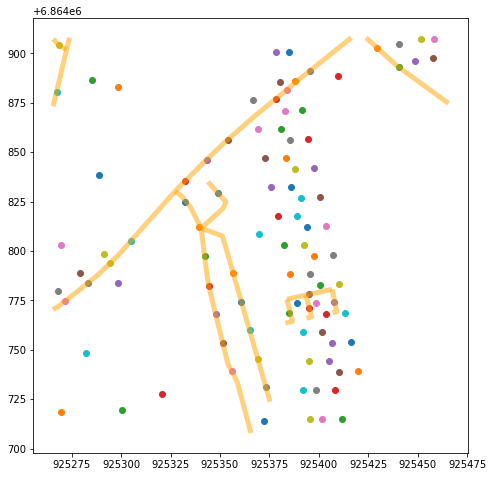

In [220]:
fig, ax = plt.subplots(figsize=(8, 8))

for p in combined_pd.centroid.tolist():
    ax.scatter(p.x,p.y)
sg_roads.plot(linewidth=5.0, edgecolor='#FFA500', color='#FFA500', alpha = 0.5,ax=ax)

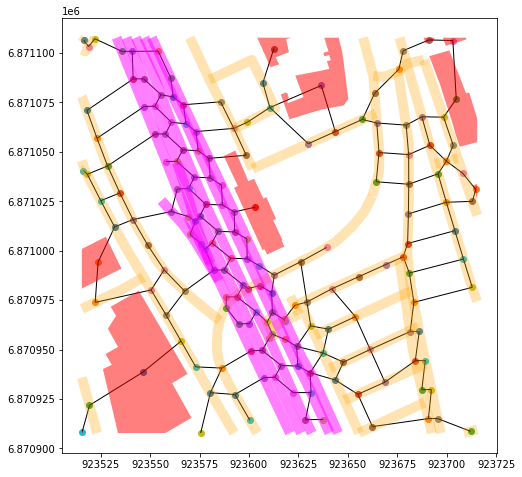

In [245]:
# sg_houses_rem =  pd.concat([sg_sport, sg_towers,sg_churches, sg_data_cemetries, sg_castels,sg_forts,sg_monuments],ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 8))

for p in combined_pd.centroid.tolist():
    ax.scatter(p.x,p.y)
nx.draw_networkx_edges(G=G, pos=pos,ax=ax)
sg_roads.plot(linewidth=10.0, edgecolor='#FFA500', color='#FFA500', alpha = 0.3, ax=ax)
sg_houses.plot(color='#FF0000', alpha = 0.5, ax=ax)
#sg_houses_rem.plot(color='#FFFF00', ax=ax)
#sg_water.plot(linewidth=10.0, color='#0000FF', alpha = 0.5, ax=ax)
sg_data_rail.plot(linewidth=10.0, color='#FF00FF',alpha = 0.5, ax=ax)
# ax.relim()
# ax.autoscale()

In [207]:
G.edges()

EdgeView([(0, 23), (99, 73), (99, 74), (99, 75), (99, 76), (99, 77), (99, 94), (99, 98), (1, 2), (3, 11), (11, 10), (4, 10), (10, 9), (6, 8), (7, 90), (90, 78), (90, 79), (12, 70), (70, 13), (70, 15), (70, 46), (70, 62), (70, 69), (13, 46), (46, 15), (46, 63), (14, 63), (63, 69), (15, 62), (62, 47), (16, 97), (97, 95), (97, 98), (17, 95), (95, 98), (18, 98), (98, 19), (98, 96), (21, 87), (87, 22), (87, 88), (22, 84), (84, 85), (24, 25), (26, 55), (55, 31), (55, 56), (55, 83), (27, 83), (83, 31), (83, 32), (83, 56), (30, 54), (44, 65), (44, 68), (68, 64), (45, 64), (45, 69), (47, 71), (71, 61), (48, 61), (48, 72), (49, 60), (49, 73), (50, 59), (50, 74), (51, 58), (51, 75), (58, 57), (52, 57), (52, 76), (76, 77), (53, 56), (53, 77), (66, 78), (78, 79), (67, 79), (81, 82), (86, 88), (92, 93)])

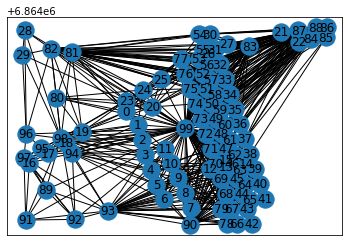

In [238]:
nx.draw_networkx(G, pos =pos)
